In [3]:
NAME = "" # put your full name here
COLLABORATORS = [] # list names of anyone you worked with on this homework.

# [ER 131] Homework 10: Classification with Decision Trees
----

This homework will build on the methods introduced in Lab 7 that predict qualitative variables. In addition to logistic regression and KNN, decision trees are a powerful prediction method and are relatively easy to interpret. A decision tree can explain exactly why a specific prediction was made. As we'll see in this HW, using a single decision tree to make a prediction often isn't the best performing method. However, ensemble methods such as random forests and bagging use multiple trees to reach a "consensus" decision and typically perform better than single decision trees. In this homework, we'll start by building a single decision tree and then see how ensemble methods perform by comparison.

Trees are, overall, a relatively accessible method for predictive modeling since they are used for both regression and classification and can take in both continuous and categorical data. Decision trees are covered in sections 8.1-8.3 of ISLR.

In this homework, we'll be doing a brief exploration of the CalEnviroScreen dataset and then implement various ensemble methods using scikit-learn. If you're up for an extra challenge, the final, optional Extra Credit section walks through how to make a decision tree from scratch. 

It'll be a comprehensive survey of trees and the multitude of algorithms that arise from one tree!


### Table of Contents

1. [The data](#data) <br>
1. [Implementing decision trees with scikit-learn](#sk) <br>
1. [Tuning regression tree hyperparameters](#hp) <br>
1. [Ensemble methods](#improve) <br>
1. [Extra Credit: Decision trees from scratch](#scratch) <br>

**Dependencies:**

In [1]:
# Load dependencies
import urllib
import os.path
from shutil import copyfile

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

In [2]:
# Install packages
!pip install xlrd
!pip install graphviz

### Section 1: The data <a name='data'></a>

In this homework, we will return to the [California Communities Environmental Health Screening Tool (CalEnviroScreen)](https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-30), which uses demographic and environmental information to identify communities that are susceptible to various types of pollution. The various variables in this dataset contribute to the CES score, which reflects a community's environmental conditions and its vulnerability to environmental pollutants.

Your HW10 folder contains an Excel file downloaded from [here](https://oehha.ca.gov/media/downloads/calenviroscreen/document/ces3results.xlsx).

Documentation on Pandas' Excel methods can be found [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html). 

**Question 1.1:** Load the "CES 3.0 (2018 Update)" sheet from the Excel file to a Pandas dataframe and assign it to the variable `df0`. If you're not sure how to do this, refer back to Lab 2.

In [6]:
# # YOUR CODE HERE

# df0 = ... 
# df0.head()

In [46]:
# Solution
filename = 'ces3results.xlsx'
xl = pd.ExcelFile(filename)
print(xl.sheet_names) # display a list of the sheets in the spreadsheet

df0 = xl.parse(xl.sheet_names[0]) # display the first sheet as Pandas dataframe
df0.head()

['CES 3.0 (2018 Update)', 'Data Dictionary', 'Missing&NAData', 'Demographic profile']


,Census Tract,Total Population,California County,ZIP,Nearby City (to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,SB 535 Disadvantaged Community,Ozone,Ozone Pctl,PM2.5,PM2.5 Pctl,Diesel PM,Diesel PM Pctl,Drinking Water,Drinking Water Pctl,Pesticides,Pesticides Pctl,Tox. Release,Tox. Release Pctl,Traffic,Traffic Pctl,Cleanup Sites,Cleanup Sites Pctl,Groundwater Threats,Groundwater Threats Pctl,Haz. Waste,Haz. Waste Pctl,Imp. Water Bodies,Imp. Water Bodies Pctl,Solid Waste,Solid Waste Pctl,Pollution Burden,Pollution Burden Score,Pollution Burden Pctl,Asthma,Asthma Pctl,Low Birth Weight,Low Birth Weight Pctl,Cardiovascular Disease,Cardiovascular Disease Pctl,Education,Education Pctl,Linguistic Isolation,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,3174,Fresno,93706,Fresno,-119.781696,36.709695,94.090246,100.000000,95-100% (highest scores),Yes,0.064889,98.182950,15.40,97.218064,48.523809,95.544493,681.195604,80.915554,2.749604,47.818560,18551.957190,97.455725,909.14,62.977817,80.5,98.668369,45.75,89.854353,0.795,84.318814,0,0.000000,21.75,97.807121,79.958783,9.848763,99.950218,131.64,97.668620,7.44,93.835704,14.13,96.309687,53.3,95.760787,16.2,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553509,99.697314
1,6071001600,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.677839,99.987388,95-100% (highest scores),Yes,0.062163,91.101431,13.31,93.637725,38.556339,92.121966,904.657603,96.108270,1.365360,41.343490,7494.236622,89.049638,782.26,55.658604,66.2,97.683327,36.00,85.567693,1.250,88.767377,5,55.007738,12.00,92.171658,81.186627,10.000000,100.000000,60.66,69.779329,7.04,90.849673,12.94,92.656776,53.3,95.760787,33.4,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067784,98.108210
2,6019000200,3167,Fresno,93706,Fresno,-119.805504,36.735491,85.970036,99.974776,95-100% (highest scores),Yes,0.062163,91.101431,15.40,97.218064,47.445208,95.420037,681.195604,80.915554,3.025629,48.753463,12454.948410,95.422799,576.52,39.002381,22.0,85.133163,30.25,81.926514,0.200,60.500463,0,0.000000,2.50,57.179910,71.157311,8.764659,99.004356,142.12,98.329385,10.16,99.782135,14.96,97.668620,42.3,89.061317,16.7,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808714,99.987388
3,6077000801,6692,San Joaquin,95203,Stockton,-121.314524,37.940517,82.491521,99.962164,95-100% (highest scores),Yes,0.046178,53.018046,12.54,84.019461,24.117036,73.515868,278.756235,29.113135,12.926266,60.560942,2387.782922,69.967573,1305.01,78.293019,50.1,96.096315,132.10,98.411122,0.795,84.318814,19,98.629228,27.00,99.103985,74.483778,9.174390,99.589297,142.17,98.341853,6.23,80.648469,14.72,97.169929,40.8,87.522079,15.3,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991499,97.717241
4,6019001500,2206,Fresno,93725,Fresno,-119.717843,36.681600,82.030814,99.949552,95-100% (highest scores),Yes,0.064889,98.182950,15.40,97.218064,18.845944,58.220286,1000.240794,98.640389,3518.413336,95.152355,21790.706720,98.154153,435.16,24.301291,60.0,97.154323,54.20,92.088712,13.100,99.703429,0,0.000000,50.80,99.905683,80.196761,9.878075,99.987554,90.48,89.539958,4.50,38.920928,12.82,92.357561,45.1,91.130457,14.7,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304332,92.760752


Let's take a look at the data for Los Angeles County.

**Question 1.2** Filter `df0` to include only those records from Los Angeles County. Then, select the columns `Census Tract`, `ZIP`, `CES 3.0 Score`, `Housing Burden`, `Unemployment`, `Poverty`, `Education`, `Traffic`, `Solid Waste`, `Pesticides`, `Groundwater Threats`, and `Pollution Burden`, and assign the resulting dataframe to `la_ft`.

*Hint:* Before you subset the dataframe `df0`, you will want to perform some data cleaning to remove trailing and leading spaces from the county names.  There is a `pandas` method that will do that for you automatically.

In [9]:
# # YOUR CODE HERE
# la_ft = ...
# la_ft.head()

In [4]:
# SOLUTION
df0["California County"] = df0["California County"].str.strip()
la = df0[df0['California County'] == 'Los Angeles']
la_ft = la[['Census Tract', 'ZIP', 'CES 3.0 Score', 'Housing Burden', 'Unemployment',
            'Poverty', 'Education', 'Traffic', 'Solid Waste', 'Pesticides', 
            'Groundwater Threats', 'Pollution Burden']]
la_ft.head()

,Census Tract,ZIP,CES 3.0 Score,Housing Burden,Unemployment,Poverty,Education,Traffic,Solid Waste,Pesticides,Groundwater Threats,Pollution Burden
5,6037204920,90023,80.726872,22.0,11.6,66.4,53.1,2943.44,3.85,0.000000,25.00,76.731417
8,6037206050,90023,79.025293,31.7,28.5,75.7,50.4,2810.82,22.10,0.000000,16.25,77.090566
14,6037205120,90023,78.043685,24.6,16.9,78.3,61.4,887.21,14.75,0.000000,37.25,75.614761
16,6037291220,90247,77.497763,37.3,8.9,53.4,31.4,2467.25,3.45,68.625026,65.55,79.989779
20,6037239202,90001,76.043426,38.7,13.6,76.3,51.4,930.42,15.00,0.000000,29.85,66.157806


In [11]:
assert la_ft.shape == (2343,12)

Let's compare two rows in our table -- specifically the records from Census Tract `6037700600` and `6037206300`. Run the following cell to load the two rows.

In [5]:
ind1 = la_ft[la_ft['Census Tract'] == 6037700600]
ind2 = la_ft[la_ft['Census Tract'] == 6037206300]
ind1.append(ind2)

,Census Tract,ZIP,CES 3.0 Score,Housing Burden,Unemployment,Poverty,Education,Traffic,Solid Waste,Pesticides,Groundwater Threats,Pollution Burden
7055,6037700600,90210,9.085757,10.9,4.4,13.4,9.5,910.71,0.5,0.057234,3.6,47.957637
123,6037206300,90013,65.941058,30.7,41.1,94.9,32.2,645.70,13.7,0.000000,13.7,69.787591


These two communities are extremely different -- one has a low CES 3.0 score and one has a high score, and the values of the features are also pretty varied. Let's take a look at how these communities compare using histograms of some of the columns.

**Question 1.3:** Create a figure with two subplots. Each subplot should show a histogram, the first the `CES 3.0 Score` and the second for `Poverty` for all Los Angeles tracts. On each subplot, mark the points at which `ind1` and `ind2` lie within the distribution (you can use a vertical line in a different color from the histogram bins). 

Use a legend or [text](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.text.html) to indicate which line corresponds to which census tract - you can call the tract with data in `ind1` "Census tract 1", and the tract with data in `ind2` "Census tract 2". Add a title and axis labels.

In [13]:
# YOUR CODE HERE

C:\Users\jessi\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jessi\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


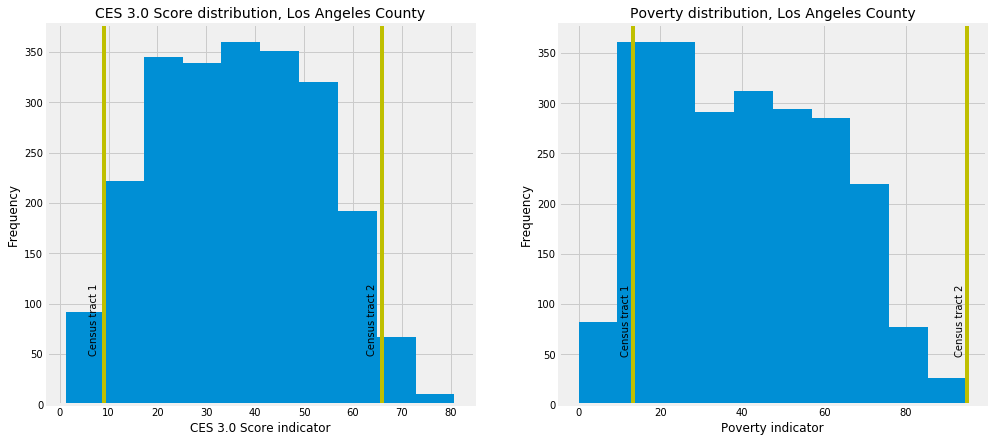

In [6]:
# SOLUTION
plt.figure(figsize = (15,7))

plots = ['CES 3.0 Score', 'Poverty']

for i in range(2):
    plt.subplot(1,2,i+1)
    plt.hist(la_ft[plots[i]])
    plt.axvline(ind1[plots[i]].values, c = 'y')
    plt.text(ind1[plots[i]].values-3, 50, "Census tract 1", fontsize = 10, rotation = 90)
    plt.axvline(ind2[plots[i]].values, c = 'y')
    plt.text(ind2[plots[i]].values-3, 50, "Census tract 2", fontsize = 10, rotation = 90)
    plt.title(plots[i] + " distribution, Los Angeles County", fontsize = 14)
    plt.xlabel(plots[i] + " indicator")
    plt.ylabel("Frequency")

Lastly, let's take a look at the demographic profiles of these two communities. This data is stored in the `Demographic profile` sheet of the Excel file.

**Question 1.4** Compare the two tracts' demographic information (i.e. display the two rows together). We've loaded the raw data from the Excel sheet into a dataframe `dp` and have renamed the columns for you. Subset `dp` to contain two rows, each containing the demographic information for one of the census tracts (much like we did right before Question 1.3).

In [7]:
# load demographic profile
dp = xl.parse('Demographic profile', header = 1)
dp = dp.reset_index()
dp = dp.rename(columns = {'Unnamed: 0': 'Census Tract',
                          'Unnamed: 1': 'CES 3.0 Score',
                          'Unnamed: 2': 'CES 3.0 Percentile',
                          'Unnamed: 3': 'CES 3.0 Percentile Range',
                          'Unnamed: 4': 'Total Population',
                          'Unnamed: 5': 'California County'
    
})

In [16]:
# YOUR CODE HERE

In [8]:
# SOLUTION
demo1 = dp[dp['Census Tract'] == 6037700600]
demo2 = dp[dp['Census Tract'] == 6037206300]
demo1.append(demo2)

,index,Census Tract,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,Total Population,California County,Children < 10 (%),Pop 11-64 years (%),Elderly > 65 (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other (%)
7055,7055,6037700600,9.085757,11.022828,10-15%,5537,Los Angeles,9.2,67.0,23.8,5.4,84.8,0.9,0.0,4.3,4.6
123,123,6037206300,65.941058,98.448733,95-100% (highest scores),7540,Los Angeles,2.0,89.1,8.9,24.9,16.7,52.8,1.0,2.3,2.2


If you're curious, you can take a look at where these census tracts are located by inputting the coordinates in [maps](https://www.google.com/maps).
- Coordinates for the first row: (+34.089264, -118.402101)
- Coordinates for second row: (+34.041111, -118.243213)

---

### Section 2. Implementing decision trees with scikit-learn<a name = 'sk'></a>


In this section, we'll be using scikit-learn's `DecisionTreeClassifier` ([documentation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)) to explore a classification prediction question for the CES 3.0 data. 

If you're interested in understanding what's going on under the hood of the scikit-learn methods, check out the Extra Credit section at the end of this HW.

In [9]:
# run this cell to import the packages we will need
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree

In this section, we'll go back to the dataframe `df0` (rather than looking only at the Los Angeles County data). In the cell below, we provide a data-cleaning operation that renames one of the qualitative columns we're going to use in building our decision tree. 

In [10]:
# Run this cell
df0.rename(columns={'CES 3.0 \nPercentile Range':'CES 3.0 Percentile Range'}, inplace = True)
df0.head()

,Census Tract,Total Population,California County,ZIP,Nearby City (to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,SB 535 Disadvantaged Community,Ozone,Ozone Pctl,PM2.5,PM2.5 Pctl,Diesel PM,Diesel PM Pctl,Drinking Water,Drinking Water Pctl,Pesticides,Pesticides Pctl,Tox. Release,Tox. Release Pctl,Traffic,Traffic Pctl,Cleanup Sites,Cleanup Sites Pctl,Groundwater Threats,Groundwater Threats Pctl,Haz. Waste,Haz. Waste Pctl,Imp. Water Bodies,Imp. Water Bodies Pctl,Solid Waste,Solid Waste Pctl,Pollution Burden,Pollution Burden Score,Pollution Burden Pctl,Asthma,Asthma Pctl,Low Birth Weight,Low Birth Weight Pctl,Cardiovascular Disease,Cardiovascular Disease Pctl,Education,Education Pctl,Linguistic Isolation,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,3174,Fresno,93706,Fresno,-119.781696,36.709695,94.090246,100.000000,95-100% (highest scores),Yes,0.064889,98.182950,15.40,97.218064,48.523809,95.544493,681.195604,80.915554,2.749604,47.818560,18551.957190,97.455725,909.14,62.977817,80.5,98.668369,45.75,89.854353,0.795,84.318814,0,0.000000,21.75,97.807121,79.958783,9.848763,99.950218,131.64,97.668620,7.44,93.835704,14.13,96.309687,53.3,95.760787,16.2,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553509,99.697314
1,6071001600,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.677839,99.987388,95-100% (highest scores),Yes,0.062163,91.101431,13.31,93.637725,38.556339,92.121966,904.657603,96.108270,1.365360,41.343490,7494.236622,89.049638,782.26,55.658604,66.2,97.683327,36.00,85.567693,1.250,88.767377,5,55.007738,12.00,92.171658,81.186627,10.000000,100.000000,60.66,69.779329,7.04,90.849673,12.94,92.656776,53.3,95.760787,33.4,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067784,98.108210
2,6019000200,3167,Fresno,93706,Fresno,-119.805504,36.735491,85.970036,99.974776,95-100% (highest scores),Yes,0.062163,91.101431,15.40,97.218064,47.445208,95.420037,681.195604,80.915554,3.025629,48.753463,12454.948410,95.422799,576.52,39.002381,22.0,85.133163,30.25,81.926514,0.200,60.500463,0,0.000000,2.50,57.179910,71.157311,8.764659,99.004356,142.12,98.329385,10.16,99.782135,14.96,97.668620,42.3,89.061317,16.7,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808714,99.987388
3,6077000801,6692,San Joaquin,95203,Stockton,-121.314524,37.940517,82.491521,99.962164,95-100% (highest scores),Yes,0.046178,53.018046,12.54,84.019461,24.117036,73.515868,278.756235,29.113135,12.926266,60.560942,2387.782922,69.967573,1305.01,78.293019,50.1,96.096315,132.10,98.411122,0.795,84.318814,19,98.629228,27.00,99.103985,74.483778,9.174390,99.589297,142.17,98.341853,6.23,80.648469,14.72,97.169929,40.8,87.522079,15.3,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991499,97.717241
4,6019001500,2206,Fresno,93725,Fresno,-119.717843,36.681600,82.030814,99.949552,95-100% (highest scores),Yes,0.064889,98.182950,15.40,97.218064,18.845944,58.220286,1000.240794,98.640389,3518.413336,95.152355,21790.706720,98.154153,435.16,24.301291,60.0,97.154323,54.20,92.088712,13.100,99.703429,0,0.000000,50.80,99.905683,80.196761,9.878075,99.987554,90.48,89.539958,4.50,38.920928,12.82,92.357561,45.1,91.130457,14.7,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304332,92.760752


----
**Question 2.1** In **your own words**, describe what the `CES 3.0 Percentile Range` category represents. What is the real-world meaning of a high score? What about a low score?

*YOUR ANSWER HERE*

*Solution reference (need to paraphrase for full credit)*

*From CalEnviroScreen: The CES score is intended to identify "... California communities that are most affected by many sources of pollution, and that are often especially vulnerable to pollution’s effects... A census tract with a high score is one that experiences higher pollution burden and vulnerability than census tracts with low scores."*

For our first model, we'll use the features to predict which score bracket a certain tract lies in - i.e. our response variable is `CES 3.0 Percentile Range`. For the sake of interpretability, we'll focus only predicting scores in the 91st percentile and above, and the 10th percentile and below.

**Question 2.2** Before we move on, what is a problem that can result from using such a specific subset of our data as our response variable?

*Your Answer Here*

*Solution: We risk training a model that can only predict the extreme scores and that will not be generally transferable to the rest of the population.*

Let's take a look at the unique values for percentile range in our target variable.

In [11]:
# run this cell
df0['CES 3.0 Percentile Range'].unique()

array(['95-100% (highest scores)', '90-95%', '85-90%', '80-85%', '75-80%',
       '70-75%', '65-70%', '60-65%', '55-60%', '50-55%', '45-50%',
       '40-45%', '35-40%', '30-35%', '25-30%', '20-25%', '15-20%',
       '10-15%', '5-10%', '1-5% (lowest scores)', nan], dtype=object)

It looks like we have a total of four values that our tree can potentially classify if we want to take the top and bottom 10% of scores.

**Question 2.3** In the cell below, create a dataframe `pct_10_90` that contains only those rows with `CES 3.0 Percentile Range` in the `96-100% (highest scores)` and `91-95%` range, as well as the `6-10%` and `1-5% (lowest scores)`.

In [22]:
# # YOUR CODE HERE
# pct_10_90 = ...

# pct_10_90.head()

In [12]:
# SOLUTION
pct_10_90 = df0[(df0['CES 3.0 Percentile Range'] == '95-100% (highest scores)') 
   | (df0['CES 3.0 Percentile Range'] == '1-5% (lowest scores)')
   | (df0['CES 3.0 Percentile Range'] == '5-10%')
   | (df0['CES 3.0 Percentile Range'] == '90-95%')]

pct_10_90.head()

,Census Tract,Total Population,California County,ZIP,Nearby City (to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,SB 535 Disadvantaged Community,Ozone,Ozone Pctl,PM2.5,PM2.5 Pctl,Diesel PM,Diesel PM Pctl,Drinking Water,Drinking Water Pctl,Pesticides,Pesticides Pctl,Tox. Release,Tox. Release Pctl,Traffic,Traffic Pctl,Cleanup Sites,Cleanup Sites Pctl,Groundwater Threats,Groundwater Threats Pctl,Haz. Waste,Haz. Waste Pctl,Imp. Water Bodies,Imp. Water Bodies Pctl,Solid Waste,Solid Waste Pctl,Pollution Burden,Pollution Burden Score,Pollution Burden Pctl,Asthma,Asthma Pctl,Low Birth Weight,Low Birth Weight Pctl,Cardiovascular Disease,Cardiovascular Disease Pctl,Education,Education Pctl,Linguistic Isolation,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,3174,Fresno,93706,Fresno,-119.781696,36.709695,94.090246,100.000000,95-100% (highest scores),Yes,0.064889,98.182950,15.40,97.218064,48.523809,95.544493,681.195604,80.915554,2.749604,47.818560,18551.957190,97.455725,909.14,62.977817,80.5,98.668369,45.75,89.854353,0.795,84.318814,0,0.000000,21.75,97.807121,79.958783,9.848763,99.950218,131.64,97.668620,7.44,93.835704,14.13,96.309687,53.3,95.760787,16.2,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553509,99.697314
1,6071001600,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.677839,99.987388,95-100% (highest scores),Yes,0.062163,91.101431,13.31,93.637725,38.556339,92.121966,904.657603,96.108270,1.365360,41.343490,7494.236622,89.049638,782.26,55.658604,66.2,97.683327,36.00,85.567693,1.250,88.767377,5,55.007738,12.00,92.171658,81.186627,10.000000,100.000000,60.66,69.779329,7.04,90.849673,12.94,92.656776,53.3,95.760787,33.4,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067784,98.108210
2,6019000200,3167,Fresno,93706,Fresno,-119.805504,36.735491,85.970036,99.974776,95-100% (highest scores),Yes,0.062163,91.101431,15.40,97.218064,47.445208,95.420037,681.195604,80.915554,3.025629,48.753463,12454.948410,95.422799,576.52,39.002381,22.0,85.133163,30.25,81.926514,0.200,60.500463,0,0.000000,2.50,57.179910,71.157311,8.764659,99.004356,142.12,98.329385,10.16,99.782135,14.96,97.668620,42.3,89.061317,16.7,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808714,99.987388
3,6077000801,6692,San Joaquin,95203,Stockton,-121.314524,37.940517,82.491521,99.962164,95-100% (highest scores),Yes,0.046178,53.018046,12.54,84.019461,24.117036,73.515868,278.756235,29.113135,12.926266,60.560942,2387.782922,69.967573,1305.01,78.293019,50.1,96.096315,132.10,98.411122,0.795,84.318814,19,98.629228,27.00,99.103985,74.483778,9.174390,99.589297,142.17,98.341853,6.23,80.648469,14.72,97.169929,40.8,87.522079,15.3,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991499,97.717241
4,6019001500,2206,Fresno,93725,Fresno,-119.717843,36.681600,82.030814,99.949552,95-100% (highest scores),Yes,0.064889,98.182950,15.40,97.218064,18.845944,58.220286,1000.240794,98.640389,3518.413336,95.152355,21790.706720,98.154153,435.16,24.301291,60.0,97.154323,54.20,92.088712,13.100,99.703429,0,0.000000,50.80,99.905683,80.196761,9.878075,99.987554,90.48,89.539958,4.50,38.920928,12.82,92.357561,45.1,91.130457,14.7,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304332,92.760752


In [13]:
assert len(pct_10_90['CES 3.0 Percentile Range'].unique()) == 4
assert pct_10_90.shape == (1585,57)

Now that we have our desired observations, let's filter the dataframe to include only those features we want to use in our classification tree. Remember that a tree can use both continuous and categorical data, but we probably don't want to work with features like the county or zip code since it would clutter our data if we wanted to encode them. Run the following cell to drop the columns as well as the NaN values.

In [14]:
pct_10_90 = pct_10_90.drop(columns = ['Census Tract', 'CES 3.0 Score', ' CES 3.0 Percentile', 
                                      'California County', 'ZIP', 'Nearby City \n(to help approximate location only)', 
                                      'Longitude', 'Latitude', 'SB 535 Disadvantaged Community'])
pct_10_90 = pct_10_90.dropna()
pct_10_90.head()

,Total Population,CES 3.0 Percentile Range,Ozone,Ozone Pctl,PM2.5,PM2.5 Pctl,Diesel PM,Diesel PM Pctl,Drinking Water,Drinking Water Pctl,Pesticides,Pesticides Pctl,Tox. Release,Tox. Release Pctl,Traffic,Traffic Pctl,Cleanup Sites,Cleanup Sites Pctl,Groundwater Threats,Groundwater Threats Pctl,Haz. Waste,Haz. Waste Pctl,Imp. Water Bodies,Imp. Water Bodies Pctl,Solid Waste,Solid Waste Pctl,Pollution Burden,Pollution Burden Score,Pollution Burden Pctl,Asthma,Asthma Pctl,Low Birth Weight,Low Birth Weight Pctl,Cardiovascular Disease,Cardiovascular Disease Pctl,Education,Education Pctl,Linguistic Isolation,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,3174,95-100% (highest scores),0.064889,98.182950,15.40,97.218064,48.523809,95.544493,681.195604,80.915554,2.749604,47.818560,18551.957190,97.455725,909.14,62.977817,80.5,98.668369,45.75,89.854353,0.795,84.318814,0,0.000000,21.75,97.807121,79.958783,9.848763,99.950218,131.64,97.668620,7.44,93.835704,14.13,96.309687,53.3,95.760787,16.2,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553509,99.697314
1,6133,95-100% (highest scores),0.062163,91.101431,13.31,93.637725,38.556339,92.121966,904.657603,96.108270,1.365360,41.343490,7494.236622,89.049638,782.26,55.658604,66.2,97.683327,36.00,85.567693,1.250,88.767377,5,55.007738,12.00,92.171658,81.186627,10.000000,100.000000,60.66,69.779329,7.04,90.849673,12.94,92.656776,53.3,95.760787,33.4,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067784,98.108210
2,3167,95-100% (highest scores),0.062163,91.101431,15.40,97.218064,47.445208,95.420037,681.195604,80.915554,3.025629,48.753463,12454.948410,95.422799,576.52,39.002381,22.0,85.133163,30.25,81.926514,0.200,60.500463,0,0.000000,2.50,57.179910,71.157311,8.764659,99.004356,142.12,98.329385,10.16,99.782135,14.96,97.668620,42.3,89.061317,16.7,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808714,99.987388
3,6692,95-100% (highest scores),0.046178,53.018046,12.54,84.019461,24.117036,73.515868,278.756235,29.113135,12.926266,60.560942,2387.782922,69.967573,1305.01,78.293019,50.1,96.096315,132.10,98.411122,0.795,84.318814,19,98.629228,27.00,99.103985,74.483778,9.174390,99.589297,142.17,98.341853,6.23,80.648469,14.72,97.169929,40.8,87.522079,15.3,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991499,97.717241
4,2206,95-100% (highest scores),0.064889,98.182950,15.40,97.218064,18.845944,58.220286,1000.240794,98.640389,3518.413336,95.152355,21790.706720,98.154153,435.16,24.301291,60.0,97.154323,54.20,92.088712,13.100,99.703429,0,0.000000,50.80,99.905683,80.196761,9.878075,99.987554,90.48,89.539958,4.50,38.920928,12.82,92.357561,45.1,91.130457,14.7,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304332,92.760752


Our final data cleaning step is to drop all of the `Pctl` columns. 

**Question 2.4** Create a dataframe `features` that contains our features. Drop all columns that contain the string `Pctl`. Don't forget to drop the `CES 3.0 Percentile Range` column. We don't want that in our features! 

Then, assign the `CES 3.0 Percentile Range` column to the variable `target`.

In [26]:
#YOUR CODE HERE
features = ...
target = ...

In [15]:
#SOLUTION 
drop_columns = [i for i in pct_10_90.columns if 'Pctl' in i]
drop_columns.append('CES 3.0 Percentile Range')

features = pct_10_90.drop(columns=drop_columns)
target = pct_10_90['CES 3.0 Percentile Range']

**Question 2.5** Lastly, create the training, testing, and validation sets. First, split the data into training and testing data. Then, split the training data into training and validation data. Use `random_state = 2020` both times, and create an 75/25 train/test split, and a 80/20 train/validation split.

*Note:* Here, `X_train` and `y_train` refer to the training set, while `X_val` and `y_val` are the validation set, and `X_test` and `y_test` are the test sets. `X` and `y` contain the training *and* validation sets, but they're just an intermediate variable in the code below. Throughout the lab, we'll be training models on `X_train` and `y_train` and using `X_val` and `y_val` to tune their hyperparameters. Then, at the very end, we'll compare how each modeling method performs on `X_test` and `y_test`. Because we'll be doing cross-validation in some but not all cases, we're reserving the 'validation' data set now that will be used for benchmarking as we go along.  But in practice it's acting like a static test data set; the error reported from the validation data set is different from cross-validated error. 

In [16]:
# # make the test/train split
# X, X_test, y, y_test = ...

# # make the train/validation split
# X_train, X_val, y_train, y_val = ...

In [17]:
# SOLUTION
# split test set
X, X_test, y, y_test = train_test_split(features, target, random_state = 2020, test_size = .25)

# split between train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 2020, test_size = 0.2)

In [18]:
assert features.shape[1] == X_test.shape[1] == 25
assert X_val.shape[0] == y_val.shape[0] == 224

### The Gini index

We are finally ready to create a tree. To interpret the outputs, you'll need one more conceptual bit of information.

When we build a tree, the first thing we need to do is decide how we'll create each split in the tree. The criterion that scikit-learn uses when checking the "quality" of a split is called the Gini index (also called Gini impurity). A low Gini index score indicates a near perfect split, and a high score means the composition of classes is nearly the same in both groups.

What does that mean? Let's say we create a split for which any census tracts where Groundwater Threats < 3 are on one branch (branch #1), and any census tracts where Groundwater Threats are >= 3 are on another branch (branch #2). If branch #1 consists of only tracts in the highest percentile range, and branch #2 consists of only tracts in the lowest percentile range, this is a perfect split and will get a low Gini index for both branches. However, if branch #1 has a 50/50 split of tracts, and so does branch #2 (i.e. there are both high percentile and low percentile tracts with Groundwater Threats >= 3), then this is a pretty bad split that doesn't really help with classification, and it will get a high Gini index score for both branches.

The Gini index is calculated as follows:

$$ G = \sum_{k = 1}^{K}{\hat{p}_k(1 - \hat{p}_k)} = 1- \sum_{k = 1}^{K} (\hat{p}^2_k)$$

where $G$ is the Gini index, and $\hat{p}_k$ is the proportion of each response class in a split, and $K$ is the total number of response classes.

A separate Gini index is calculated for each branch of a split, and then a weighted Gini index can be calculated for the overall split, where the weight corresponds to the number of observations in each split.

**Question 2.6** Let's say we create a tree with one split, predicting a response variable with 2 classes (class 1 and class 2). We have 20 observations in total. One of the tree branches (branch #1) encompasses 2 observations of class 1 and 8 observations of class 2. The other tree branch (branch #2) encompasses 7 observations of class 1 and 3 observations of class 2. Calculate: 
1. The Gini index for branch #1
1. The Gini index for branch #2
1. The weighted Gini index

In [ ]:
# YOUR CODE HERE
gini1 = ...
gini2 = ...
ginitotal = ...
print("branch 1:", gini1)
print("branch 2:", gini2)
print("weighted:", ginitotal)

In [19]:
# Solution
gini1 = 1-(2/10)**2-(8/10)**2
gini2 = 1-(7/10)**2-(3/10)**2
ginitotal = 0.5*gini1 + 0.5*gini2
print("branch 1:", gini1)
print("branch 2:", gini2)
print("weighted:", ginitotal)

branch 1: 0.31999999999999984
branch 2: 0.42000000000000004
weighted: 0.36999999999999994


In [58]:
np.square(8.0/10.0), (8/10)**2

(0.6400000000000001, 0.6400000000000001)

Back to scikit-learn...

**Question 2.7** Instantiate a `DecisionTreeClassifer` model and call it `first_tree`. Fit the model using the training data, and score it using both the training and validation set. Assign the scores to the variables `train_score` and `val_score` respectively. 

Remember: the general syntax for all scikit-learn models is the same, so if you're not sure where to start, take a look at the documentation for `DecisionTreeClassifier` as well as previous assignments that use scikit-learn models.

In [ ]:
# YOUR CODE HERE
first_tree = ...
first_tree.fit(...)

print("Number of features: {}".format(first_tree.tree_.n_features))
print("Number of nodes (internal and terminal): {}".format(first_tree.tree_.node_count), "\n")

train_score = first_tree.score(...)
val_score = first_tree.score(...)

print('Train Score: ', train_score)
print('Validation Score: ', val_score)

In [25]:
#SOLUTION
first_tree = DecisionTreeClassifier(random_state=2020)
first_tree.fit(X_train, y_train)

print("Number of features: {}".format(first_tree.tree_.n_features))
print("Number of nodes (internal and terminal): {}".format(first_tree.tree_.node_count), "\n")

train_score = first_tree.score(X_train, y_train)
val_score = first_tree.score(X_val, y_val)

print('Train Score: ', train_score)
print('Validation Score: ', val_score)

Number of features: 25
Number of nodes (internal and terminal): 111 

Train Score:  1.0
Validation Score:  0.9151785714285714


The score isn't too shabby for a tree that was put together pretty quickly! One nice aspect of decision trees is that they're easy to visualize and interpret and with scikit-learn, we can export the an image of the tree. Unfortunately, due limitations on DataHub, we can't output an image directly in a notebook. Luckily, we can copy the code and visualize the tree on [Webgraphviz](http://webgraphviz.com). Run the following cell. Then copy the entire output into the dialogue box on Webgraphvis. You should get a visualization of the decision tree we fit!

In [21]:
import graphviz
print(tree.export_graphviz(first_tree, feature_names=X.columns))

digraph Tree {
node [shape=box] ;
0 [label="Pop. Char.  <= 52.933\ngini = 0.749\nsamples = 896\nvalue = [209, 221, 230, 236]"] ;
1 [label="Pop. Char.  <= 14.962\ngini = 0.5\nsamples = 430\nvalue = [209, 221, 0, 0]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Pollution Burden Score <= 4.497\ngini = 0.307\nsamples = 164\nvalue = [133, 31, 0, 0]"] ;
1 -> 2 ;
3 [label="Haz. Waste <= 0.117\ngini = 0.034\nsamples = 114\nvalue = [112, 2, 0, 0]"] ;
2 -> 3 ;
4 [label="gini = 0.0\nsamples = 101\nvalue = [101, 0, 0, 0]"] ;
3 -> 4 ;
5 [label="Pollution Burden <= 33.888\ngini = 0.26\nsamples = 13\nvalue = [11, 2, 0, 0]"] ;
3 -> 5 ;
6 [label="gini = 0.0\nsamples = 11\nvalue = [11, 0, 0, 0]"] ;
5 -> 6 ;
7 [label="gini = 0.0\nsamples = 2\nvalue = [0, 2, 0, 0]"] ;
5 -> 7 ;
8 [label="Pop. Char.  <= 10.616\ngini = 0.487\nsamples = 50\nvalue = [21, 29, 0, 0]"] ;
2 -> 8 ;
9 [label="Ozone <= 0.05\ngini = 0.165\nsamples = 22\nvalue = [20, 2, 0, 0]"] ;
8 -> 9 ;
10 [label="gini =

**Question 2.8** You'll notice that each box in the output tree has four rows of information. What does each line in a given box in the Webgraphviz visualization represent?

***YOUR ANSWER HERE*** <br>
First line:

Second line:

Third line:

Fourth Line:

*Solution*

*First line: The value of the feature at which the internal node (split) is placed<br>
Second line: The Gini index, as calculated above<br>
Third line: The number of samples in the branch<br>
Fourth line: The number of samples in each of the four classification categories (`CES 3.0 Percentile Range` in the '1-5% (lowest scores)', '5-10%', '90-95%', and '95-100% (highest scores)' classes)*

**Question 2.9** Based on the visualization, what might your infer about which features are most important in terms of classification?

*Your answer here*

*Solution*

*We might infer that features associated with the earlier splits in the tree and/or the features that appear in many splits are very important; these appear to be 'Pop. Char. Score' and 'Pollution Burden Score.'* 

----
With scikit-learn, we're also able to check the feature importance. Running the following cell, we can see the features and the their importance based on the data we used to fit the tree -- this can be helpful when tuning or pruning the tree! The feature importance is a measure of how much of a decrease in the Gini index results from including that feature.

In [26]:
pd.DataFrame({'Feature': X.columns, 'Importance': first_tree.feature_importances_})

,Feature,Importance
0,Total Population,0.002115
1,Ozone,0.010379
2,PM2.5,0.001985
3,Diesel PM,0.004876
4,Drinking Water,0.000000
5,Pesticides,0.004267
6,Tox. Release,0.005265
7,Traffic,0.000000
8,Cleanup Sites,0.000000
9,Groundwater Threats,0.000000


**Question 2.10**  To visualize these results, write a function `importance_plot` takes in a model e.g., `first_tree`), and does the the following:
* Calculates the *relative* feature importance, which is each feature's importance divided by the maximum feature importance multiplied by 100. Relative feature importances (and the associated features) should be saved in a dataframe called `feat_df`. 
* Creates a bar plot showing the names of the features on the y-axis and their relative importance on the x-axis. The features should be plotted in descending order of importance. 

Use your function to create an importance plot for `first_tree`. 

In [ ]:
def importance_plot(tree):
    # YOUR CODE HERE
    feature_importance = ... # get the importance of each feature
    
    #calculate the relative feature importance and save to a dataframe with two columns: 
    # One holding the names of the features, and one holding the associated relative importance 
    # of each feature.
    relative_importance = ...
    feat_df = ...
    
    # Sort feat_df in order of importance
    feat_df = ...
    
    plt.figure(figsize=(8, 7.5))
    plt.barh(width=..., y=...)
    plt.xlabel('Relative feature importance');

In [62]:
def importance_plot(tree):
    # SOLUTION
    feature_importance = tree.feature_importances_
    
    #relative feature importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    feat_df = pd.DataFrame({'feature':X_train.columns, 'importance':feature_importance})
    
    feat_df = feat_df.sort_values(by='importance', ascending=True)
    
    plt.figure(figsize=(8, 7.5))
    plt.barh(width=feat_df.importance, y=feat_df.feature)
    plt.xlabel('Relative feature importance');

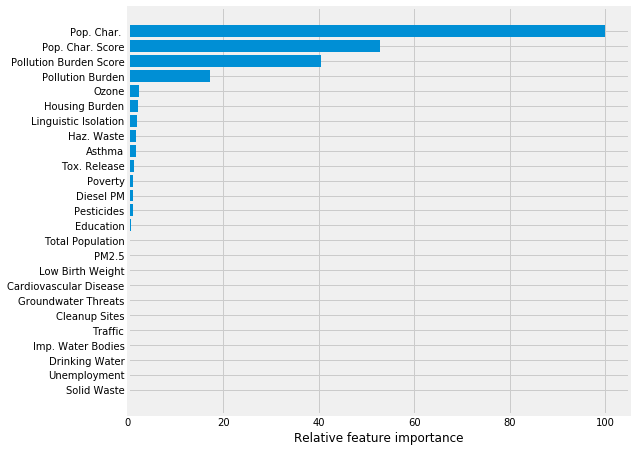

In [63]:
importance_plot(first_tree)

**Question 2.11** Which features have the highest relative importance scores? Are these features consistent with those you identified in 2.9? 

*YOUR ANSWER HERE*

*SOLUTION*

*Indeed, the variables associated with Population Characteristics and Pollution Burden have relatively high importance scores.*

-----
## Section 3: Tuning regression tree hyperparameters <a name = 'hp'></a>

We've had a good look at what we can do with a decision tree in using scikit-learn. Let's dive into learning about the hyperparameters, which can help improve our classification model. Again, the documentation for `DecisionTreeClassifier` is linked [here](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

Our `first_tree` contained *lot* of nodes. Some of these nodes have a gini score of 0 or have small sample numbers. We can overcome these problems by adjusting the hyperparameters of the tree. 

**Quesiton 3.1** In the following cell, we have almost the exact same code from earlier, but we've added two parameters: `max_leaf_nodes` and `max_features`. What do these two parameters represent? Try two or three sets of different values for these two parameters and see if you can improve our original model.

In [ ]:
# YOUR CODE HERE
tuned_tree = DecisionTreeClassifier(max_leaf_nodes=..., max_features=...)
tuned_tree.fit(X_train, y_train)

print("Number of features: {}".format(tuned_tree.tree_.n_features))
print("Number of nodes (leaves): {}".format(tuned_tree.tree_.node_count),"\n")

tuned_train_score = tuned_tree.score(X_train, y_train)
tuned_val_score = tuned_tree.score(X_val, y_val)

print('Train Score: ', tuned_train_score)
print('Validation Score: ', tuned_val_score)

In [29]:
# possible solution
tuned_tree = DecisionTreeClassifier(max_leaf_nodes=5, max_features=25)
tuned_tree.fit(X_train, y_train)

print("Number of features: {}".format(tuned_tree.tree_.n_features))
print("Number of nodes (leaves): {}".format(tuned_tree.tree_.node_count),"\n")

tuned_train_score = tuned_tree.score(X_train, y_train)
tuned_val_score = tuned_tree.score(X_val, y_val)

print('Train Score: ', tuned_train_score)
print('Validation Score: ', tuned_val_score)

Number of features: 25
Number of nodes (leaves): 9 

Train Score:  0.7633928571428571
Validation Score:  0.7857142857142857


**Solution**
* `max_leaf_nodes`: the maximum number of allowed terminal nodes (i.e., leaves)
* `max_features`: the maximum number of allowed features to consider when looking for the best split

Were you able to obtain validation score higher than what we had originally (it's ok if you didn't!)? It probably took some time to figure out which values were better than others.

Fortunately, we don't have to test various parameters by manually inputting them and running the cell, which would be exhausting! Instead, we can use [`RandomizedSearchCV` from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) to help us find hyperparameters that lower our error. 

`RandomizedSeachCV` takes in a model, a distribution of parameters we want to test in the model, and other parameters that we can adjust. Of the latter, we'll only use `cv` and `n_iter` along with the two required arguments. 

The parameter distribution is a dictionary that takes in the parameter name as a key and a range of random values that we want to test. We'll be using `randint` from scipy.stats. Read through and then run the following cell -- we will also fit the CV search which will take some time.

In [31]:
# run this cell
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {'max_leaf_nodes': randint(3, 100),
              'max_features': randint(2, 25),
              'max_depth': randint(1, 10)}

rnd_search = RandomizedSearchCV(tuned_tree, param_distributions=param_dist, 
                                cv=10, n_iter=200, random_state = 2020)
rnd_search.fit(X_train, y_train)

C:\Users\jessi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=25,
                                                    max_leaf_nodes=5,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='best'),
  

**Question 3.2** What does `cv` represent in the `RandomizedSearchCV` function above?

*YOUR ANSWER HERE*

*Solution: `cv` sets the number of folds that the method uses in k-fold cross-validation.*

After fitting our data, we can check the score and the values for the parameters that return the "best" score. Run the following cell to get these values.

In [32]:
print(rnd_search.best_score_) # This is cross validation error from the training data set.
print(rnd_search.best_params_)

0.9118303571428571
{'max_depth': 8, 'max_features': 18, 'max_leaf_nodes': 89}


**Question 3.3** Set the parameters of `tuned_tree` to the 3 parameters that we found using the randomized search. Then, score the model using the training and validation sets. Hopefully this tuned tree performed better than our original one (due to the random samples, this isn't guaranteed!). 

In [ ]:
# YOUR CODE HERE
...
...

tuned_train_score = ...
tuned_val_score = ...

print('Train Score: ', tuned_train_score)
print('Validation Score: ', tuned_val_score)

In [35]:
#SOLUTION
tuned_tree.set_params(max_features=18, max_leaf_nodes=8, max_depth = 8)
tuned_tree.fit(X_train, y_train)

tuned_train_score = tuned_tree.score(X_train, y_train)
tuned_val_score = tuned_tree.score(X_val, y_val)

print('Train Score: ', tuned_train_score)
print('Validation Score: ', tuned_val_score)

tuned_tree.tree_.node_count

Train Score:  0.8258928571428571
Validation Score:  0.8258928571428571


25

**Question 3.4** Print out a table showing the feature importance score for the tuned_tree like we did for the initial tree instantiation, and then use `importance_plot` to visualize the results. How does feature importance in the tuned tree compared to that in the first tree?

In [ ]:
# YOUR CODE HERE

In [29]:
# YOUR CODE HERE

In [36]:
pd.DataFrame({'Feature':X_train.columns, 'Importance': tuned_tree.feature_importances_})

,Feature,Importance
0,Total Population,0.000000
1,Ozone,0.000000
2,PM2.5,0.000000
3,Diesel PM,0.000000
4,Drinking Water,0.000000
5,Pesticides,0.000000
6,Tox. Release,0.000000
7,Traffic,0.000000
8,Cleanup Sites,0.000000
9,Groundwater Threats,0.000000


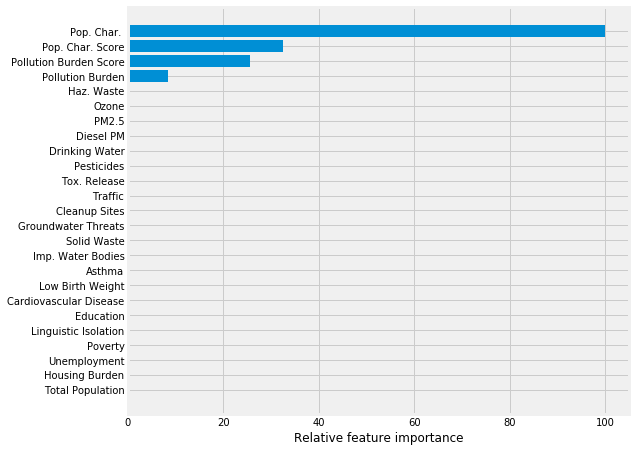

In [37]:
importance_plot(tuned_tree)

*YOUR ANSWER HERE*

Lastly, for this tuned tree, let's take a look at how adjusting the hyperparameters altered the decision tree. Like last time, copy and paste the code into [Webgraphviz](http://webgraphviz.com) to visualize the tree.

In [38]:
print(tree.export_graphviz(tuned_tree, feature_names=X.columns))

digraph Tree {
node [shape=box] ;
0 [label="Pop. Char.  <= 52.933\ngini = 0.749\nsamples = 896\nvalue = [209, 221, 230, 236]"] ;
1 [label="Pop. Char. Score <= 1.552\ngini = 0.5\nsamples = 430\nvalue = [209, 221, 0, 0]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
3 [label="Pollution Burden <= 36.513\ngini = 0.307\nsamples = 164\nvalue = [133, 31, 0, 0]"] ;
1 -> 3 ;
13 [label="gini = 0.034\nsamples = 114\nvalue = [112, 2, 0, 0]"] ;
3 -> 13 ;
14 [label="gini = 0.487\nsamples = 50\nvalue = [21, 29, 0, 0]"] ;
3 -> 14 ;
4 [label="gini = 0.408\nsamples = 266\nvalue = [76, 190, 0, 0]"] ;
1 -> 4 ;
2 [label="Pollution Burden Score <= 7.428\ngini = 0.5\nsamples = 466\nvalue = [0, 0, 230, 236]"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="Pop. Char. Score <= 8.76\ngini = 0.432\nsamples = 260\nvalue = [0, 0, 178, 82]"] ;
2 -> 5 ;
9 [label="gini = 0.268\nsamples = 182\nvalue = [0, 0, 153, 29]"] ;
5 -> 9 ;
10 [label="Pollution Burden Score <= 6.188

Let's move on to more improvements we can make to decision tree models.

----

### Section 4: Ensemble methods<a name = 'improve'></a>

In the previous section, we were focusing on fitting one tree and tuning its hyperparameters. You may have noticed that, although the training scores were extremely high, the validation scores usually weren't as high. This is where ensemble methods (namely, bagging, random forests, and boosting) come in. We call them "ensemble methods" because we fit many trees and then aggregate the models to avoid overfitting. The benefits of using ensemble methods may not be immediately apparent with the training and validation data, but might become clearer when we evaluate all our models on the test data at the end of the assignment.

**Question 4.1a** Distinguish among bagging, random forests, and boosting. What kind of ensemble methodology does each use?

*YOUR ANSWER HERE*

*SOLUTION*
*Bagging bootstraps new datasets from the original data to fit many decision trees and then averages across all the decision trees. Random forests use the same approach as bagging, but only use a random subset of features when fitting individual trees. Boosting sequentially builds trees such that each tree is fit to lower the previous tree's residuals.* 


**Question 4.1b** Name at least one advantage and one drawback of using an ensemble method compared to a single decision tree.

*YOUR ANSWER HERE*

*Solution: Ensemble methods reduce variance at the price of interpretability (we cannot, for example, visualize a random forest in the same we can a regression tree).* 

----

Let's start with bagging!

Bagging takes in $B$ different bootstrapped training data sets and trains a tree on each $b$th training set to get $\hat{f}^{*b}(x)$. Then, it averages all of the predictions to get 

$$\hat{f}_{bag}(x) = \frac{1}{B} \sum_{b=1}^{B}\hat{f}^{*b}(x)$$

In terms of classifying, bagging records the associated with each bootstrapped sample and chooses the most commonly occurring majority class among the B predictions.

Let's proceed by using `BaggingClassifier` from scikit-learn's ensemble module ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)). 

**Question 4.2** Use the training data (`X_train` and `y_train`) to fit the bagging classifier. Call your model `bag_tree`. Score the model using the validation data.  Use `random_state=2020`, `n_estimators = 125`, `max_samples = 500`, `max_features = 20`.

In [ ]:
# YOUR CODE HERE
from sklearn.ensemble import BaggingClassifier

bag_tree = ...
...

bag_train_score = ...
bag_val_score = ...

print('Train Score: ', bag_train_score)
print('Validation Score: ', bag_val_score)

In [41]:
# solution
from sklearn.ensemble import BaggingClassifier

bag_tree = BaggingClassifier(random_state = 2020, n_estimators = 125, max_samples = 500, max_features = 20)
bag_tree.fit(X_train, y_train)

bag_train_score = bag_tree.score(X_train, y_train)
bag_val_score = bag_tree.score(X_val, y_val)

print('Train Score: ', bag_train_score)
print('Validation Score: ', bag_val_score)

Train Score:  0.9988839285714286
Validation Score:  0.9375


**Question 4.3**  Note that as opposed to the single tree we fit before, we don't need to cross-validate `max_depth`, `max_features`, and `max_leaf_nodes` hyperparameters.  Why?

*Your answer here*

*Solution: With a single tree, we tune these hyperparameters to balance the bias variance tradeoff. With ensemble methods, we reduce variance by randomly generating many regression trees and taking the average.*

----
Now, we'll move on to random forests.

Random forests take a similar approach to bagging, in which we fit various decision trees on resampled data. But, when each tree is constructed, not every feature is considered as split candidates for each decision point; we only take a subset of the total predictors in the model.

The idea behind a random forest is that adding randomization into the features that create the model and then averaging predictions across models will produce a model that is not as overfit to the training data, and is in turn more reliable for prediction.

We'll use scikit-learn's `RandomForestClassifier()` to implement our model. The documentation can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

**Question 4.4** Create a RandomForestClassifier, fit the training data, and score the model. Call the model `rf_tree`.

In [ ]:
# YOUR CODE HERE
from sklearn.ensemble import RandomForestClassifier

rf_tree = ...
...

rf_train_score = ...
rf_val_score = ...

print('Train Score: ', rf_train_score)
print('Validation Score: ', rf_val_score)

In [44]:
# solution
from sklearn.ensemble import RandomForestClassifier

rf_tree = RandomForestClassifier(random_state=2020)
rf_tree.fit(X_train, y_train)

rf_train_score = rf_tree.score(X_train, y_train)
rf_val_score = rf_tree.score(X_val, y_val)

print('Train Score: ', rf_train_score)
print('Validation Score: ', rf_val_score)

Train Score:  0.9977678571428571
Validation Score:  0.9151785714285714


C:\Users\jessi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


**Question 4.5** Review the scikit-learn documentation on random forests to identify which hyperparameters might improve model performance.  In particular, what is `max_depth`, and what should you choose it to be? (You might want to consult with lecture notes and the textbook for guidance.) 

*Your answer here*

*Solution:* max_depth is a hyperparameter that describes the maximum number of levels of each tree in the forest. A deeper tree will include more splits, but risks overfitting the data. However, since random forests deal with variance by averaging the outputs of many trees, it's ok to grow these trees deep. 

**Question 4.6** Decide what other hyperparameters will affect model performance (things like tree depth, maximum number of observations per leaf, etc).  Choose values for those parameters and pass them in to a new random forest classifier and fit the model, then print out errors with training and validation data. Call your model `rf_newparams`. How does it perform relative to the default model you built in Question 4.4?

In [ ]:
# YOUR CODE HERE
rf_newparams = RandomForestClassifier(...)

...

...

print(...)

In [45]:
#solution
rf_newparams = RandomForestClassifier(max_features="auto", max_leaf_nodes = None,
                    min_samples_leaf=1, min_samples_split=2, n_estimators=100, 
                    random_state = 3)
rf_newparams.fit(X_train, y_train)

rf_train_score = rf_newparams.score(X_train, y_train)
rf_val_score = rf_newparams.score(X_val, y_val)

print('Train Score: ', rf_train_score)
print('Validation Score: ', rf_val_score)

Train Score:  1.0
Validation Score:  0.9419642857142857


*YOUR ANSWER HERE*

----
Lastly, we'll cover boosting, which is yet another approach to improve a decision tree model. The boosting approach grows a tree slowly. Each boosting algorithm has a slightly different approach, but the general idea is the same behind each one.

scikit-learn has two boosting algorithms. We'll focus on `GradientBoostingClassifer`. For your awareness, the other algorithm is `AdaBoostClassifier` (for ADAptive BOOSTing). The adaptive part of the algorithm comes from how it updates the data for each weak model in the sequence; it combines many relatively weak and inaccurate classifiers. So it shines when a regular classifier doesn't perform well with a given dataset. However, it doesn't handle noisy data or outliers well. With our CES 3.0 response variable in this case, our data is basically polarized -- we're taking values from the top and bottom 10% -- which means it might not work as well as we want it to.

So, we'll use `GradientBoostingClassifier` instead. Gradient boosting involves three elements:
1. A loss function to be optimized.
2. A weak learner to make predictions.
3. An additive model in which we add weak learners to minimize the loss function.

We'll use scikit-learn's `GradientBoostingClassifier` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)) to see how it performs with our data.

**Question 4.7** We'll do this for the last time! Fit the training data to the GradientBoostingClassifier and score the model. How much did it improve over the original model?

In [ ]:

# YOUR CODE HERE 
from sklearn.ensemble import GradientBoostingClassifier

...
...

gb_train_score = ...
gb_val_score = ...

print('Train Score: ', gb_train_score)
print('Validation Score: ', gb_val_score)

In [47]:
# solution
from sklearn.ensemble import GradientBoostingClassifier

gb_tree = GradientBoostingClassifier()
gb_tree.fit(X_train, y_train)

gb_train_score = gb_tree.score(X_train, y_train)
gb_val_score = gb_tree.score(X_val, y_val)

print('Train Score: ', gb_train_score)
print('Validation Score: ', gb_val_score)

Train Score:  1.0
Validation Score:  0.9508928571428571


**Question 4.8** In the case of boosting, cross validation helps with hyperparameter tuning.  Figure out what parameters you'd like to search over, choose a range for them, and pass them into `RandomizedSearchCV` as we did in part 3.  Then save and print out the best parameters. (*NOTE:* This will probably take a while--several minutes!--to run, depending on how many parameters you choose.)

In [ ]:
param_dist = {...}

rnd_gb_search = RandomizedSearchCV(gb_tree,..)

rnd_gb_search.fit(X_train, y_train)

print(rnd_gb_search.best_params_)

In [49]:
#POSSIBLE SOLUTION

param_dist = {'learning_rate': randint(1, 5),
              #'max_leaf_nodes': randint(3, 100),
              'max_features': randint(2, 25),
              'max_depth': randint(1, 10),
              'min_samples_leaf': randint(1, 30)}

rnd_gb_search = RandomizedSearchCV(gb_tree, param_distributions=param_dist, 
                                cv=10, n_iter=50)

rnd_gb_search.fit(X_train, y_train)

print(rnd_gb_search.best_params_)

C:\Users\jessi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 1, 'max_depth': 7, 'max_features': 13, 'min_samples_leaf': 18}


**Question 4.9** Once the search is complete, set the parameters and re-fit and score the model.

In [ ]:
# YOUR CODE HERE
...
...

gb_train_score = ...
gb_val_score = ...

print('Train Score: ', gb_train_score)
print('Validation Score: ', gb_val_score)

In [50]:
# SOLUTION
gb_tree.set_params(learning_rate=1, max_depth=9, max_features=9, max_leaf_nodes=47, 
                   min_samples_leaf=3)
gb_tree.fit(X_train, y_train)

print('Train Score: ', gb_tree.score(X_train, y_train))
print('Validation Score: ', gb_tree.score(X_val, y_val))

Train Score:  1.0
Validation Score:  0.9464285714285714


**Question 4.10** Use `importance_plot` to visualize the relative importance of the features in `gb_tree`. How do the results compare to the `tuned_tree` feature importance?

In [ ]:
# YOUR CODE HERE

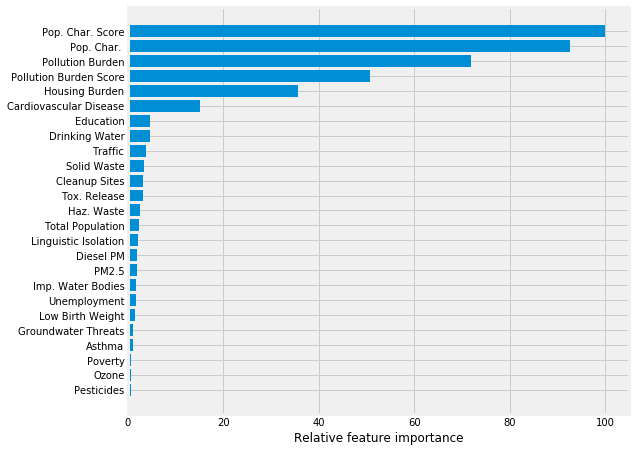

In [51]:
importance_plot(gb_tree)

*YOUR ANSWER HERE*

----

We've gone through many methods of creating a decision tree and tuning and improving it, as well as various algorithms that use multiple trees to create a more reliable prediction. Even though we've primarily have been testing our models with the training and validation set, we would still need to cross validate each of these models to see which one is the optimal one to choose given our data and how the model performs (this is even more important when a lot of the scores turned up around 92-93%). 

Before you finish up this homework, run the following cell. Which model scores the highest on the test data? Which scores the lowest?

In [52]:
models = [first_tree, tuned_tree, bag_tree, rf_tree, rf_newparams, gb_tree]
for i in models:
    print('Test Score: ', i.score(X_test, y_test))

Test Score:  0.8689839572192514
Test Score:  0.7352941176470589
Test Score:  0.9090909090909091
Test Score:  0.8743315508021391
Test Score:  0.8957219251336899
Test Score:  0.9171122994652406


*YOUR ANSWER HERE*

----

## Extra Credit: A Decision Tree from Scratch

Even though trees are pretty easy to interpret, a lot goes into creating them. This optional exercise walks through creating a tree and is intended to help solidify you intuition about what's going on behind the scenes in scikit-learn.

There are a few things that we're going to do here to make this process more digestible -- e.g., we're taking a small sample from the table and we are classifying only the top and bottom groups of the CES dataset.

Run the cell below create a new dataframe, `extremes`. It should contain data for tracts with the highest percentile score and lowest percentile score. For simplicity, the dataframe contains only 3 columns: "Drinking Water", "Unemployment", and "CES 3.0 Percentile Range".
</div>

In [ ]:
# run this cell
extremes = df0[(df0['CES 3.0 Percentile Range'] == '95-100% (highest scores)') 
               | (df0['CES 3.0 Percentile Range'] == '1-5% (lowest scores)')]

extremes = extremes[["Drinking Water", "Unemployment","CES 3.0 Percentile Range"]]

extremes.head()

As you can probably guess from the dataframe `extremes`, we're going to build a tree that predicts whether a census tract is in the lowest or highest percentile range of CalEnviroScreen scores based on the value of its Drinking Water and Unemployment metrics.

**Question EC 1** Take a look at the following cell, which contains the code to calculate the gini index. There are letters following three pound symbols. Write down what the lines of code below each letter are doing.

In [ ]:
def gini_index(groups, classes):
    ### A ###
    n_instances = float(sum([len(group) for group in groups]))
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        for class_val in classes:
            ### B###
            p = [row[-1] for row in group].count(class_val) / size
            ### C ###
            score += p * p
        ### D ###
        gini += (1.0 - score) * (size / n_instances)
    return gini

**A:** What is n_instances?<br>
**B:** What does `p` represent in each iteration of the `for` loop in which it is nested?
<br>
**C** How is `score` updated in each iteration of the `for` loop in which it is nested? <br>
**D** What does this line do?

*Solution*

*A:* Count the number of samples (at the split point)<br>
*B:* The number of instances of a particular class divided by the number of items in the group.<br>
*C:* With each iteration, the square of `p` for a particular class is added to the squares of `p` for all preceding classes. <br> 
*D:* Calculates the Gini index for a group (i.e., a branch) and weights the index according to its size relative to the sample. 

------

Now, we can work towards creating a split. Ultimately, we'll want to evaluate a range of possible splits using the Gini index. For now, we need a function that creates one split.

Splitting a dataset means separating a dataset into two lists based on how a feature (with a column number indicated by `index`) compares to a value (`value`). Once we have the two lists, we can use the Gini index above to evaluate the cost of the split (a step which will be implemented in a later function).

Run the following cell to load the function.

In [ ]:
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

**EC 2** What does the group sorted in the left list represent?

*Your answer here*

*Solution*

The left group contains all rows of the `dataset` in which the value the feature associated with the `index` is less than the split `value`.

----
We can create our splits now. Given a dataset, we must check every value on each feature as a candidate split, evaluate the cost of the split using the Gini index and find the best possible split we can make. The lowest Gini score across all the features would then be chosen as the best split and a node would be created.

We will use a dictionary to represent a node in the decision tree. When selecting the best split and using it as a new node, we will store the index of the chosen feature, the value of that feature by which to split and the two groups of data split by the chosen split point.

The function below runs this procedure. Run the cell to load function.

In [ ]:
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index = index
                b_value = row[index]
                b_score = gini
                b_groups = groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

We have all of the tools to find the best splits of the tree -- let's see how we can use them to *build* one from the ground up (or from the top since trees are inverted...). 

Building a tree takes two main steps: finding leaves (e.g. when to stop the tree) and recursively splitting the tree.

The following cell contains the function that returns the most common output in a list of rows.

In [ ]:
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

----

We're almost there! The following cell contains the function that performs the recursive splitting. 

Here are the steps of this procedure:

1. `split()` takes `node` as input, which is the dictionary returned by `get_split()`. The two lists of data returned by `get_split()` are extracted and deleted from the node. The node no longer requires access to these data.
2. We check if either left or right group of rows is empty and if so we create a terminal node using the data and computed scores we have.
3. Check if we have reached our maximum depth. If we have, create a terminal node.
4. If the left group of rows is too small, we process the left child and create a terminal node. Otherwise, we create and add the left node in a depth-first fashion until the bottom of the tree is reached on this branch.
5. Right side is then processed in the same manner, as we rise back up the constructed tree to the root.

**Question EC 3** Similar to question 2.2, look at the following cell and note what each control case is doing in the `split` function.

In [ ]:
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    ### A ###
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    ### B ###
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    ### C ###
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    ### D ###
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

*YOUR ANSWER HERE*

**Solution**
- a. check for an empty split
- b. check for max depth
- c. process left child
- d. process right child

----

Awesome! We're ready to build our tree. In the following cell, we have our `build_tree` and `print_tree` function. Most of the steps were abstracted away in `get_split` and `split` functions. Before we use the function, 

**Question EC 4** We can't directly use a pandas dataframe or series as input to this function. In the cell below, convert `extremes` to a numpy array and assign it to the variable `rows`. Run the cell and see the resulting tree.

In [ ]:
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

# YOUR CODE HERE       
rows = extremes.values
scratch_tree = build_tree(rows, 2, 2)
print_tree(scratch_tree)

**Question EC 5** In the outputs above, what do each of the inequalities represent? State your answer in terms of the independent and response variables we used from the CES 3.0 data.

*YOUR ANSWER HERE*

*Solution*

The inequalities represent the internal nodes (i.e., the splits of the tree). In our dataframe, X2 is Unemployment and X1 is Drinking Water. 
* The first internal node occurs at an Unemployment percent of 8.8. 
* If Unemployment is <8.8%, the next internal node occurs at a Drinking Water contaminant index of 635.016. If the Drinking Water value is lower than 635.016, the CES Percentile is predicted to be in the lowest score category; if it is greater, then the CES Percentile is predicted to be in the highest score category.
* If Unemployment is >= 8.8%, the next internal node occurs at a Drinking Water contaminant index of 197.416. If the Drinking Water value is lower than 197.416, the CES Percentile is predicted to be in the lowest score category; if it is greater, then the CES Percentile is predicted to be in the highest score category.

----

Just for fun, we can also use this tree for prediction. Run the following cell to see the expected and predicted values from our dataset!

In [ ]:
# run this cell
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

for row in rows:
    prediction = predict(scratch_tree, row)
    print('Expected: ', row[-1])
    print('Got: ', prediction, '\n')

----

## Submission

Congrats, you're done with Homework 10! 

In order to turn in this assignment, go to the toolbar and click **File** -> **Download as** -> **.html** and **.ipynb**. Submit the files through bCourses.

----

Notebook developed by: Jason Jiang

Data Science Modules: http://data.berkeley.edu/education/modules